In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pgmpy.models import BayesianNetwork, LinearGaussianBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, ExpectationMaximization, BayesianEstimator
from pgmpy.estimators import HillClimbSearch, BicScore, K2Score, BDsScore
import matplotlib.pyplot as plt
from pgmpy.inference import VariableElimination
import networkx as nx

In [22]:
def visualise(model, pos, projectile_color="skyblue", interceptor_color="lightcoral"):
    edges = model.edges()

    # Create a directed graph object
    G = nx.DiGraph()

    # Add edges to the graph
    G.add_edges_from(edges)

    # Create a color map based on node type
    color_map = []
    for node in G.nodes():
        if "P_" in node:
            color_map.append(projectile_color)
        elif "I_" in node:
            color_map.append(interceptor_color)
        else:
            color_map.append("gray")  # Default color for any other nodes

    # Plot the graph with custom positions and colors
    plt.figure(figsize=(20, 12))
    nx.draw(G, pos, with_labels=True, node_size=1000, node_color=color_map, font_size=8, font_weight="bold", arrowsize=10)
    plt.title("Bayesian Network Graph")
    plt.show()

In [23]:
# Define positions manually
pos = {}

for i in range(6):

    if i % 2 == 0:
        # Projectile nodes positions (lower row)
        pos[f'P_FP{i}'] = ((i * 3)  , 0)
        pos[f'P_D{i}'] = ((i * 3 - 1)  , -1)
        pos[f'P_V{i}'] = ((i * 3 + 1)  , -1)
        pos[f'P_IP{i}'] = ((i * 3 - 1)  , -2)
        pos[f'P_A{i}'] = ((i * 3 + 1)  , -2)

        # Interceptor nodes positions (upper row)
        pos[f'I_FP{i}'] = (i * 3, 3)
        pos[f'I_D{i}'] = (i * 3 - 1, 2)
        pos[f'I_V{i}'] = (i * 3 + 1, 2)
        pos[f'I_IP{i}'] = (i * 3 - 1, 1)
        pos[f'I_A{i}'] = (i * 3 + 1, 1)
    else:
         # Projectile nodes positions (lower row)
        pos[f'P_FP{i}'] = ((i * 3)  , (0) - 1)
        pos[f'P_D{i}'] = ((i * 3 - 1)  ,( -1) - 1)
        pos[f'P_V{i}'] = ((i * 3 + 1)  , (-1) - 1)
        pos[f'P_IP{i}'] = ((i * 3 - 1)  , (-2) - 1)
        pos[f'P_A{i}'] = ((i * 3 + 1)  , (-2) - 1)

        # Interceptor nodes positions (upper row)
        pos[f'I_FP{i}'] = (i * 3, (3) + 1)
        pos[f'I_D{i}'] = (i * 3 - 1, (2) + 1)
        pos[f'I_V{i}'] = (i * 3 + 1, (2) + 1)
        pos[f'I_IP{i}'] = (i * 3 - 1, (1) + 1)
        pos[f'I_A{i}'] = (i * 3 + 1, (1) + 1)


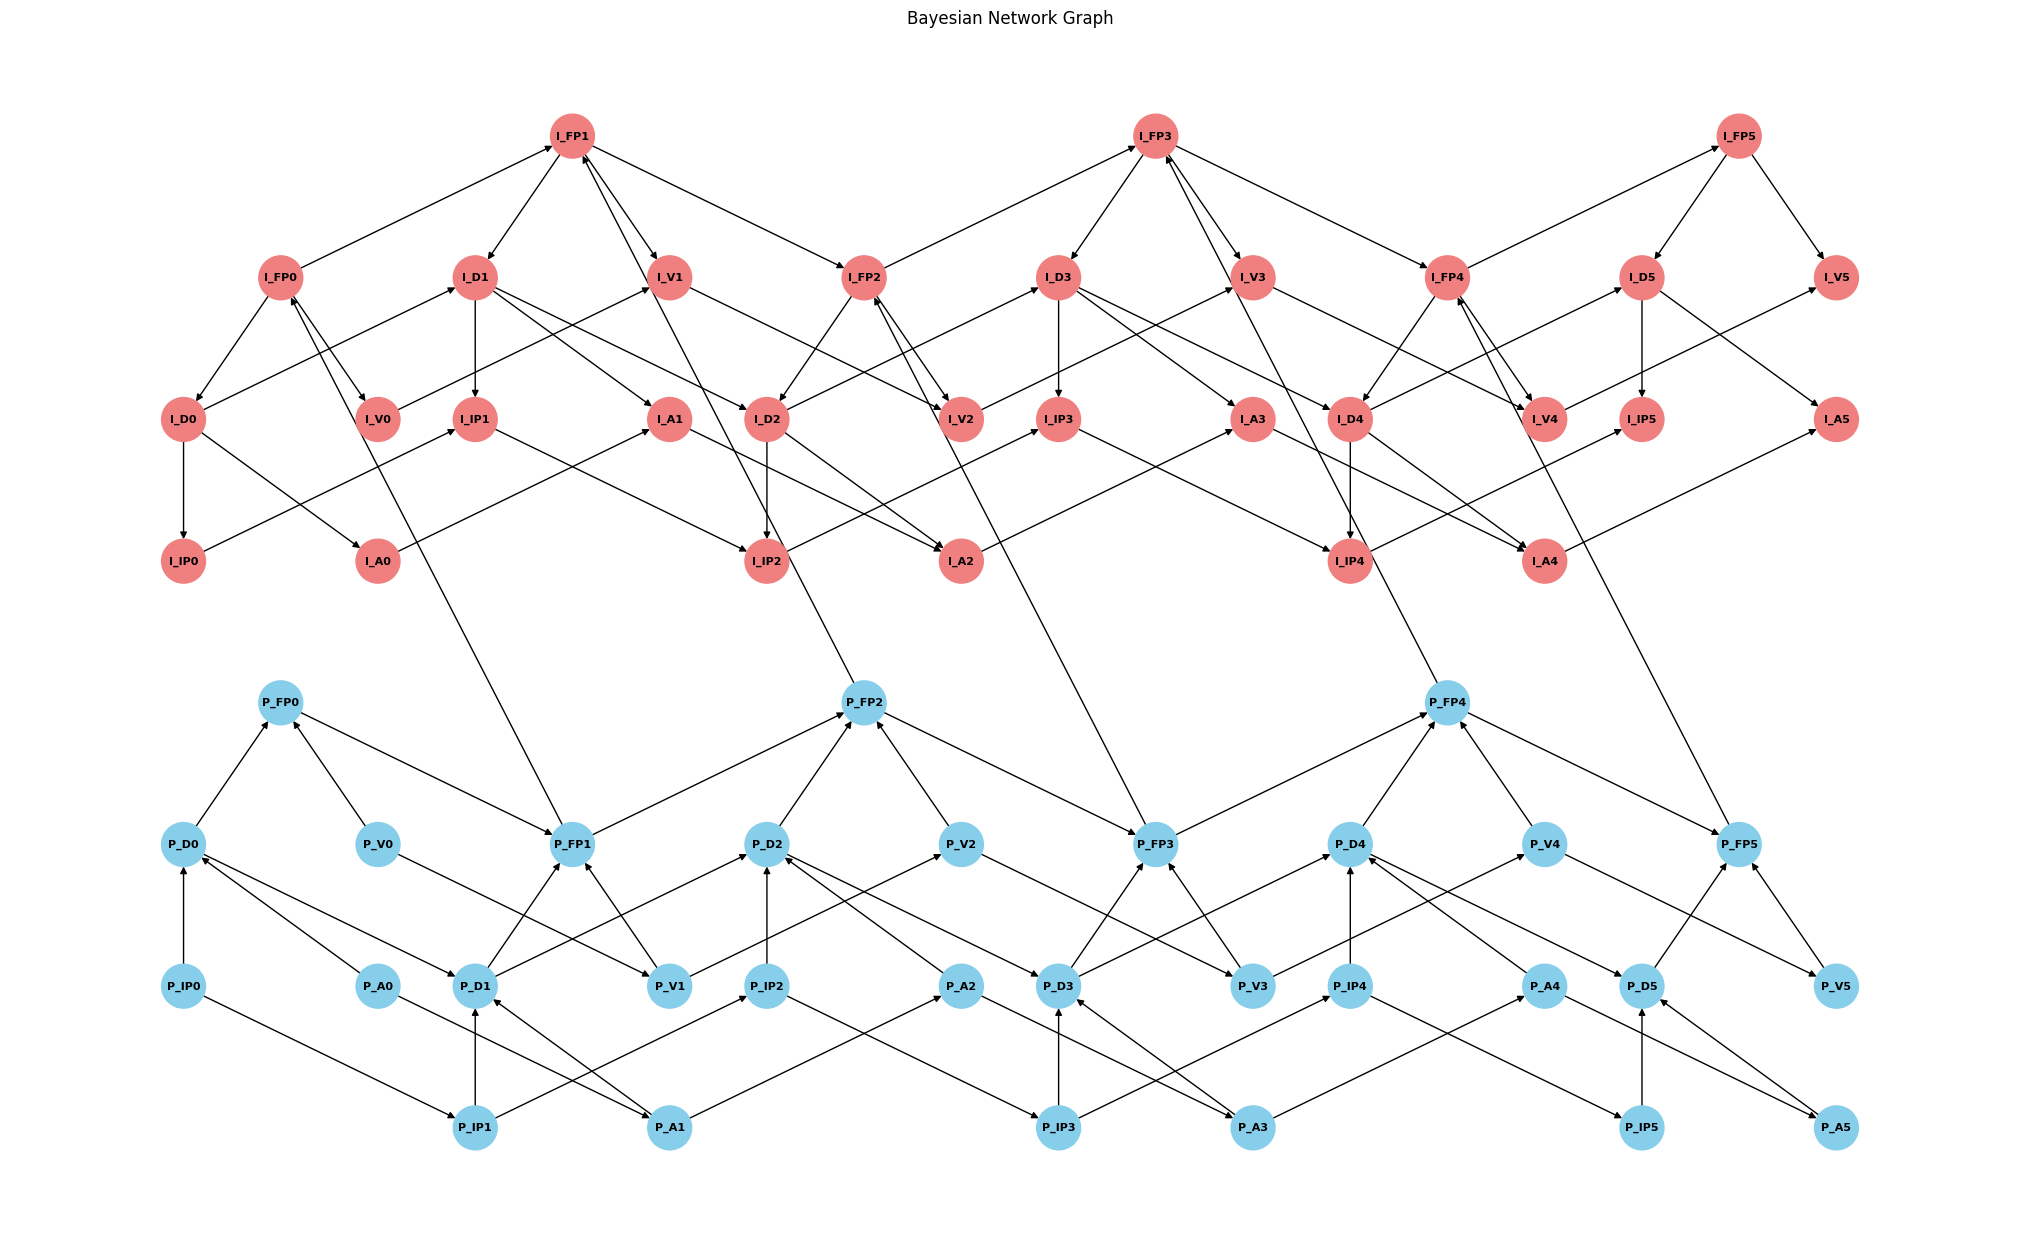

In [24]:
from pgmpy.factors.continuous import LinearGaussianCPD
from pgmpy.models import LinearGaussianBayesianNetwork

# Initialize the Bayesian Network model
GT = LinearGaussianBayesianNetwork()

for i in range(6):
    GT.add_nodes_from([
        f'P_FP{i}', f'P_D{i}', f'P_V{i}',
        f'P_IP{i}', f'P_A{i}',
        f'I_FP{i}', f'I_D{i}', f'I_V{i}',
        f'I_IP{i}', f'I_A{i}'
    ])
    
    GT.add_edges_from([
        ( f'P_D{i}', f'P_FP{i}'),
        (f'P_IP{i}', f'P_D{i}'),
        (f'P_A{i}', f'P_D{i}'),
        ( f'P_V{i}',f'P_FP{i}'),
        ( f'I_FP{i}', f'I_D{i}'),
        (f'I_D{i}',f'I_IP{i}'),
        (f'I_D{i}',f'I_A{i}'),
        ( f'I_FP{i}',f'I_V{i}')
    ])

    if i < 5:
        # Connect corresponding nodes between time slices
        GT.add_edges_from([
            (f'P_FP{i}', f'P_FP{i + 1}'),
            (f'P_D{i}', f'P_D{i + 1}'),
            (f'P_V{i}', f'P_V{i + 1}'),
            (f'P_IP{i}', f'P_IP{i + 1}'),
            (f'P_A{i}', f'P_A{i + 1}'),
            (f'I_FP{i}', f'I_FP{i + 1}'),
            (f'I_D{i}', f'I_D{i + 1}'),
            (f'I_V{i}', f'I_V{i + 1}'),
            (f'I_IP{i}', f'I_IP{i + 1}'),
            (f'I_A{i}', f'I_A{i + 1}')
        ])
        
        # Edge between interceptor and projectile across time slices
        GT.add_edge(f'P_FP{i + 1}', f'I_FP{i}')

visualise(GT, pos)


In [25]:
# CPDs for Projectile Nodes
for i in range(6):
    if i == 0:
        cpd_P_FP = LinearGaussianCPD(
            f'P_FP{i}', 
            [5.0, 0.9, 0.7],  # Assuming offset is replaced with beta's first value
            2.0, 
            [ f'P_V{i}', f'P_D{i}']
        )

        cpd_P_D = LinearGaussianCPD(
            f'P_D{i}', 
            [0.0, 0.5, 0.3],  # Assuming offset is replaced with beta's first value
            0.5,
            [f'P_A{i}', f'P_IP{i}']
        )

        cpd_P_V = LinearGaussianCPD(
            f'P_V{i}', 
            [20.0, 0.9, 0.3],  # Assuming offset is replaced with beta's first value
            1.0, 
            []
        )

        cpd_P_IP = LinearGaussianCPD(
            f'P_IP{i}',
            [0.0],  # No evidence, so beta is just the offset value
            0.1,
            []
        )

        cpd_P_A = LinearGaussianCPD(
            f'P_A{i}',
            [45.0],  # No evidence, so beta is just the offset value
            0.1,
            []
        )
    else:
        cpd_P_FP = LinearGaussianCPD(
            f'P_FP{i}', 
            [5.0, 0.9, 0.7],  # Assuming offset is replaced with beta's first value
            2.0, 
            [ f'P_V{i}', f'P_D{i}', f'P_FP{i - 1}']
        )

        cpd_P_D = LinearGaussianCPD(
            f'P_D{i}', 
            [0.0, 0.5, 0.3],  # Assuming offset is replaced with beta's first value
            0.5,
            [f'P_A{i}', f'P_IP{i}',  f'P_D{i - 1}']
        )

        cpd_P_V = LinearGaussianCPD(
            f'P_V{i}', 
            [20.0, 0.9, 0.3],  # Assuming offset is replaced with beta's first value
            1.0, 
            [ f'P_V{i - 1}']
        )

        cpd_P_IP = LinearGaussianCPD(
            f'P_IP{i}',
            [0.0],  # No evidence, so beta is just the offset value
            0.1,
            [f'P_IP{i - 1}']
        )

        cpd_P_A = LinearGaussianCPD(
            f'P_A{i}',
            [45.0],  # No evidence, so beta is just the offset value
            0.1,
            [f'P_A{i - 1}']
        )


    # Add CPDs to the network
    GT.add_cpds(cpd_P_FP, cpd_P_D, cpd_P_V, cpd_P_IP, cpd_P_A)

# CPDs for Interceptor Nodes
for i in range(6):

    if i == 0:

        if i < 5:
            cpd_I_FP = LinearGaussianCPD(
                f'I_FP{i}', 
                [5.0, 0.9, 0.7, 0.8],  # Assuming offset is replaced with beta's first value
                3.0, 
                [f'P_FP{i+1}']
            )
        else:
            cpd_I_FP = LinearGaussianCPD(
                f'I_FP{i}', 
                [5.0, 0.9, 0.7, 0.8],  # Assuming offset is replaced with beta's first value
                3.0, 
                []
            )

        cpd_I_D = LinearGaussianCPD(
            f'I_D{i}', 
            [0.0, 0.5, 0.3, 0.2],  # Assuming offset is replaced with beta's first value
            0.5,
            [ f'I_FP{i}']
        )

        cpd_I_V = LinearGaussianCPD(
            f'I_V{i}', 
            [15.0, 0.8, 0.3, 0.3],  # Assuming offset is replaced with beta's first value
            1.5, 
            [f'I_FP{i}']
        )

        cpd_I_IP = LinearGaussianCPD(
            f'I_IP{i}',
            [0.0],  # No evidence, so beta is just the offset value
            0.1,
            [f'I_D{i}']
        )

        cpd_I_A = LinearGaussianCPD(
            f'I_A{i}',
            [45.0],  # Depends on the projectile's angle
            0.2,
            [f'I_D{i}']
        )

    else:
        if i < 5:
            cpd_I_FP = LinearGaussianCPD(
                f'I_FP{i}', 
                [5.0, 0.9, 0.7, 0.8],  # Assuming offset is replaced with beta's first value
                3.0, 
                [f'P_FP{i+1}',  f'I_FP{i - 1}']
            )
        else:
            cpd_I_FP = LinearGaussianCPD(
                f'I_FP{i}', 
                [5.0, 0.9, 0.7, 0.8],  # Assuming offset is replaced with beta's first value
                3.0, 
                [f'I_FP{i - 1}']
            )

        cpd_I_D = LinearGaussianCPD(
            f'I_D{i}', 
            [0.0, 0.5, 0.3, 0.2],  # Assuming offset is replaced with beta's first value
            0.5,
            [ f'I_FP{i}', f'I_D{i - 1}']
        )

        cpd_I_V = LinearGaussianCPD(
            f'I_V{i}', 
            [15.0, 0.8, 0.3, 0.3],  # Assuming offset is replaced with beta's first value
            1.5, 
            [f'I_FP{i}',  f'I_V{i - 1}']
        )

        cpd_I_IP = LinearGaussianCPD(
            f'I_IP{i}',
            [0.0],  # No evidence, so beta is just the offset value
            0.1,
            [f'I_D{i}' , f'I_IP{i - 1}']
        )

        cpd_I_A = LinearGaussianCPD(
            f'I_A{i}',
            [45.0],  # Depends on the projectile's angle
            0.2,
            [f'I_D{i}' ,  f'I_A{i - 1}']
        )


    # Add CPDs to the network
    GT.add_cpds(cpd_I_FP, cpd_I_D, cpd_I_V, cpd_I_IP, cpd_I_A)

In [29]:
import numpy as np

# Assuming mean is a dictionary where each key is a variable name and each value is the mean of that variable
mean = {}  # This should be populated with the actual mean values for each variable

def get_cpd_details(network):
    for node in network.nodes():
        cpd = network.get_cpds(node)
        if isinstance(cpd, LinearGaussianCPD):
            mean_parameters = cpd.mean
            
            # Check if the number of coefficients matches the number of evidence variables
            if len(mean_parameters[1:]) != len(cpd.evidence):
                print(f"ERROR: Mismatch in the number of coefficients and evidence for {node}")
                print(f"Number of coefficients: {len(mean_parameters[1:])}, Number of evidence variables: {len(cpd.evidence)}")
                continue
            
            # Ensure the mean dictionary contains all necessary variables
            for evidence_var in cpd.evidence:
                if evidence_var not in mean:
                    mean[evidence_var] = 0  # Default to 0 if not yet defined; replace with actual mean if known

            evidence_means = [mean[evidence_var] for evidence_var in cpd.evidence]
            
            print(f"Variable: {node}")
            print(f"CPD Mean Parameters: {mean_parameters}")
            print(f"Evidence Variables: {cpd.evidence}")
            print(f"Evidence Means: {evidence_means}")
            
            try:
                calculated_mean = np.dot(mean_parameters[1:], evidence_means) + mean_parameters[0]
                print(f"Calculated Mean for {node}: {calculated_mean}")
            except Exception as e:
                print(f"FAILED: {e}")
            print('-' * 40)
        else:
            print(f"Node {node} does not have a LinearGaussianCPD.")

# Example of using this with your network
get_cpd_details(GT)

# Validation
if GT.check_model():
    print("The model is valid!")
else:
    print("The model is not valid. Please check the CPDs and network structure.")


Variable: P_FP0
CPD Mean Parameters: [5.  0.9 0.7]
Evidence Variables: ['P_V0', 'P_D0']
Evidence Means: [0, 0]
Calculated Mean for P_FP0: 5.0
----------------------------------------
Variable: P_D0
CPD Mean Parameters: [0.  0.5 0.3]
Evidence Variables: ['P_A0', 'P_IP0']
Evidence Means: [0, 0]
Calculated Mean for P_D0: 0.0
----------------------------------------
Variable: P_V0
CPD Mean Parameters: [20.   0.9  0.3]
Evidence Variables: []
Evidence Means: []
NO EVIDENCE
----------------------------------------
Variable: P_IP0
CPD Mean Parameters: [0.]
Evidence Variables: []
Evidence Means: []
NO EVIDENCE
----------------------------------------
Variable: P_A0
CPD Mean Parameters: [45.]
Evidence Variables: []
Evidence Means: []
NO EVIDENCE
----------------------------------------
Variable: I_FP0
CPD Mean Parameters: [5.  0.9 0.7 0.8]
Evidence Variables: ['P_FP1']
Evidence Means: [0]
FAILED
----------------------------------------
Variable: I_D0
CPD Mean Parameters: [0.  0.5 0.3 0.2]
Eviden

In [ ]:
import numpy as np
import pandas as pd

def sample_from_joint_gaussian(mean, covariance, size=1):
    """Samples from a joint Gaussian distribution with given mean and covariance."""
    mean = np.array(mean).flatten()
    covariance = np.array(covariance)
    
    if mean.shape[0] != covariance.shape[0]:
        raise ValueError("Mean and covariance dimensions do not match.")
    
    return np.random.multivariate_normal(mean, covariance, size=size)

def forward_sample_from_dbn(JGD, n_samples=1000):
    """Perform forward sampling from a joint Gaussian distribution."""
    # Extract mean and covariance from the joint Gaussian distribution
    mean = JGD.mean.flatten()
    covariance = JGD.covariance
    
    # Sample from the joint Gaussian distribution
    sampled_data = sample_from_joint_gaussian(mean, covariance, size=n_samples)
    
    # Create a DataFrame from the sampled data
    sample_df = pd.DataFrame(sampled_data, columns=JGD.variables)
    
    return sample_df

# Generate samples
n_samples = 1000
JGD = GT.to_joint_gaussian()
samples_df = forward_sample_from_dbn(JGD, n_samples=n_samples)

# Save to CSV
samples_df.to_csv("trajectory_data.csv", index=False)
print(f"Generated {n_samples} samples and saved to trajectory_data.csv")



ValueError: operands could not be broadcast together with shapes (3,) (2,) 

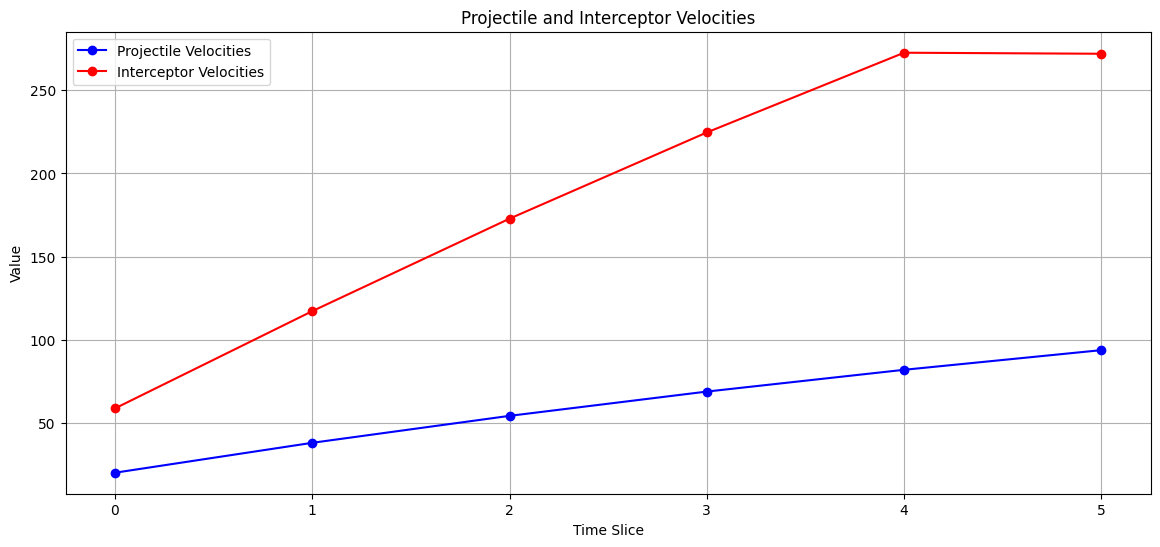

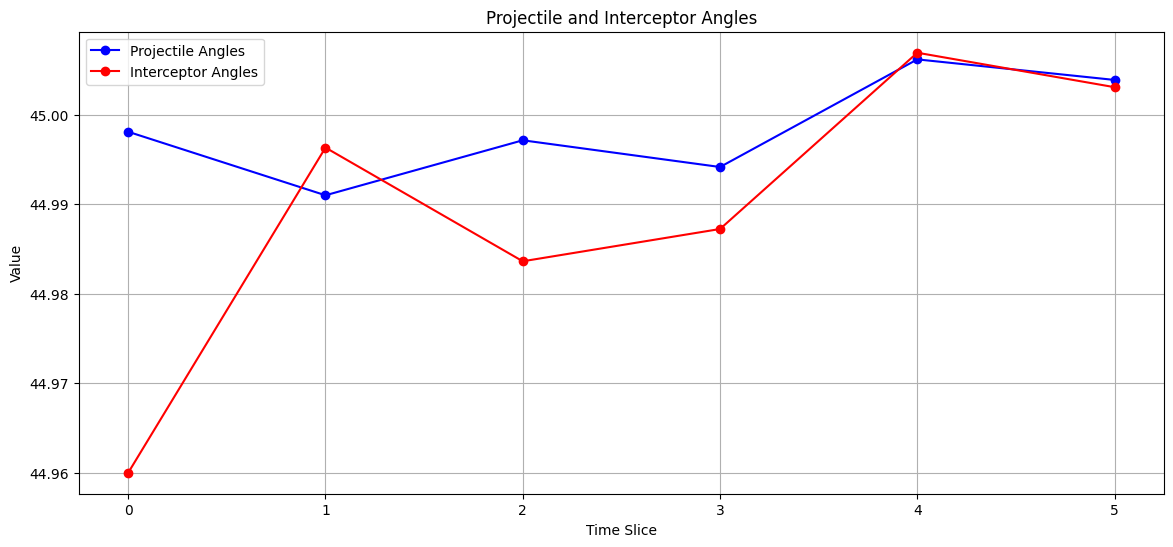

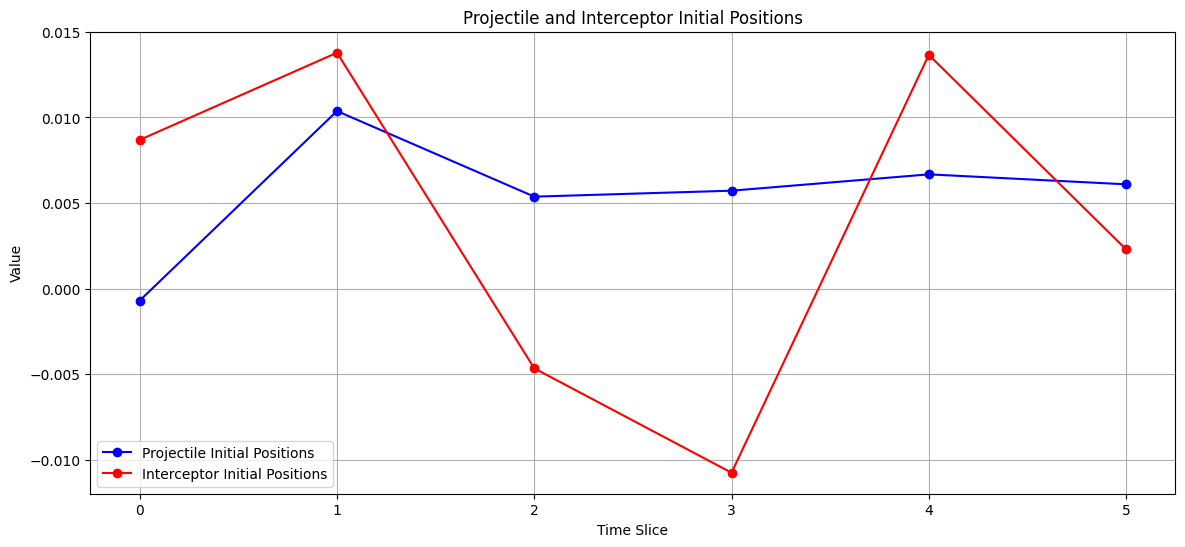

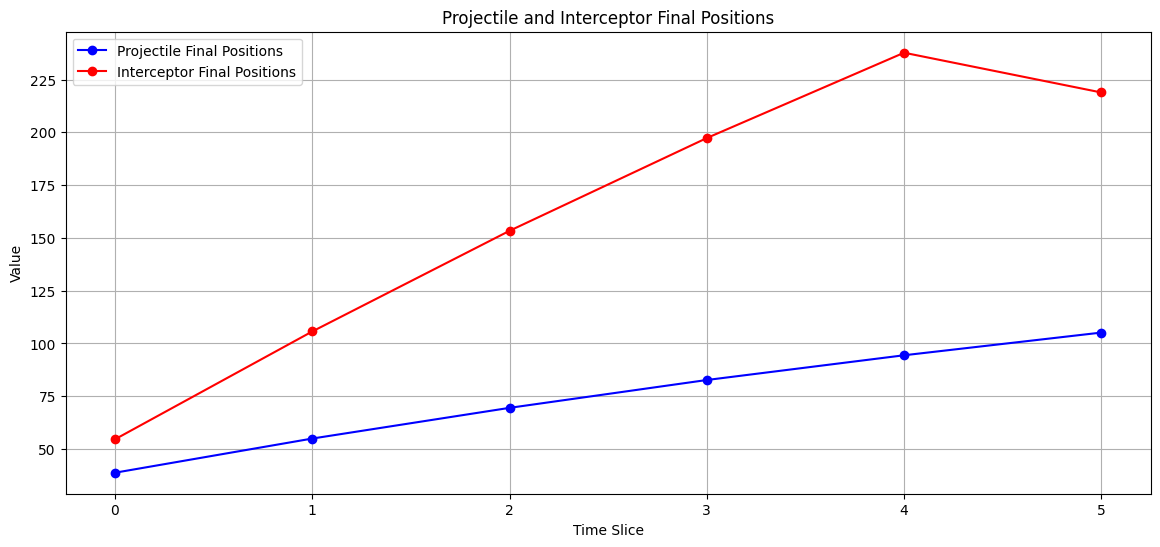

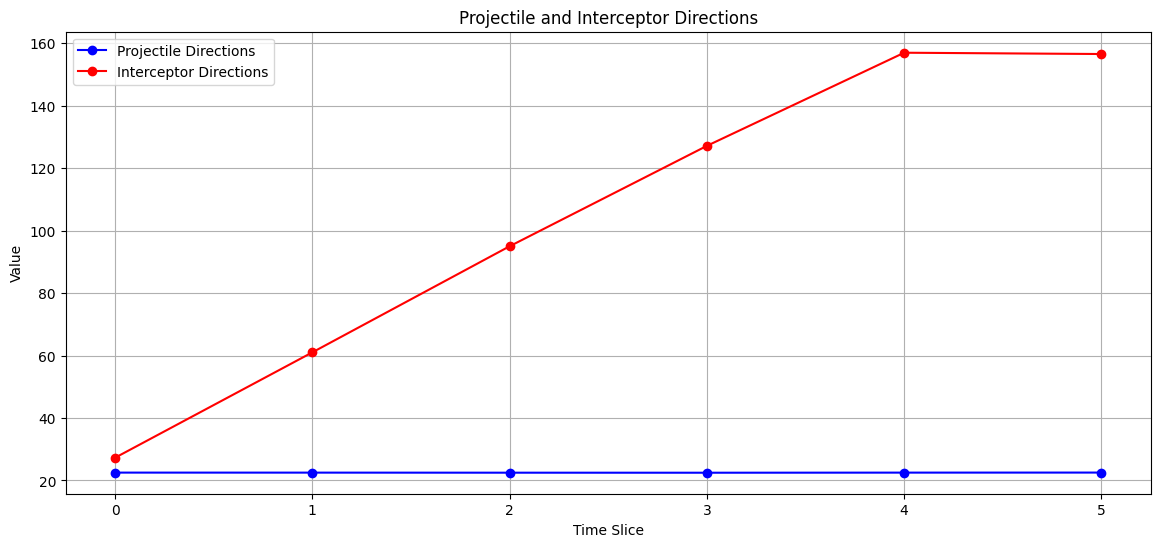

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
file_path = 'trajectory_data.csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Convert all columns to numeric, forcing non-numeric values to NaN
data = data.apply(pd.to_numeric, errors='coerce')

# Define time slices
time_slices = [0, 1, 2, 3, 4, 5]

# Define columns to plot for velocities and angles
projectile_velocities = ['P_V0', 'P_V1', 'P_V2', 'P_V3', 'P_V4', 'P_V5']
interceptor_velocities = ['I_V0', 'I_V1', 'I_V2', 'I_V3', 'I_V4', 'I_V5']
projectile_angles = ['P_A0', 'P_A1', 'P_A2', 'P_A3', 'P_A4', 'P_A5']
interceptor_angles = ['I_A0', 'I_A1', 'I_A2', 'I_A3', 'I_A4', 'I_A5']
projectile_ips = [f'P_IP{i}' for i in range(6)]
projectile_fps = [f'P_FP{i}' for i in range(6)]
projectile_ds = [f'P_D{i}' for i in range(6)]
interceptor_ips = [f'I_IP{i}' for i in range(6)]
interceptor_fps = [f'I_FP{i}' for i in range(6)]
interceptor_ds = [f'I_D{i}' for i in range(6)]

# Function to plot velocities or angles
def plot_values(data, projectile_columns, interceptor_columns, title, label):
    plt.figure(figsize=(14, 6))
    
    # Plot projectile velocities
    plt.plot(time_slices, data[projectile_columns].mean(axis=0), marker='o', label='Projectile ' + label, color='blue')
    
    # Plot interceptor velocities
    plt.plot(time_slices, data[interceptor_columns].mean(axis=0), marker='o', label='Interceptor ' + label, color='red')
    
    plt.xlabel('Time Slice')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)

# Plot velocities for projectile and interceptor
plot_values(data, projectile_velocities, interceptor_velocities, 'Projectile and Interceptor Velocities', "Velocities")
plt.show()

# Plot angles for projectile and interceptor
plot_values(data, projectile_angles, interceptor_angles, 'Projectile and Interceptor Angles', "Angles")
plt.show()

# Plot velocities for projectile and interceptor
plot_values(data, projectile_ips, interceptor_ips, 'Projectile and Interceptor Initial Positions', "Initial Positions")
plt.show()

# Plot angles for projectile and interceptor
plot_values(data, projectile_fps, interceptor_fps, 'Projectile and Interceptor Final Positions', "Final Positions")
plt.show()

# Plot velocities for projectile and interceptor
plot_values(data, projectile_ds, interceptor_ds, 'Projectile and Interceptor Directions', "Directions")
plt.show()



In [ ]:
from pgmpy.estimators import HillClimbSearch, BicScore, K2Score, BDsScore

def learn_structure(data,max_indegree):

    hc = HillClimbSearch(data)

    if (max_indegree > 0):
        best_modelBic = hc.estimate(scoring_method=BicScore(data), max_indegree=max_indegree)
    else:
        best_modelBic = hc.estimate(scoring_method=BicScore(data))
        
    print(best_modelBic.nodes())
    print(best_modelBic.edges())
    
    return best_modelBic.edges()

     P_V0  P_IP0  P_A0  P_V1  P_IP1  P_D0  P_A1  P_V2  P_IP2  P_FP0  ...  \
0    21.0   -0.0  45.0  39.0   -0.0  21.0  44.0  55.0   -0.0   35.0  ...   
1    19.0    0.0  45.0  38.0    0.0  23.0  45.0  52.0    1.0   38.0  ...   
2    19.0   -0.0  45.0  37.0   -0.0  22.0  45.0  55.0    0.0   39.0  ...   
3    20.0    0.0  45.0  38.0    0.0  23.0  45.0  53.0    0.0   37.0  ...   
4    20.0    0.0  45.0  35.0    0.0  22.0  45.0  51.0    0.0   37.0  ...   
..    ...    ...   ...   ...    ...   ...   ...   ...    ...    ...  ...   
995  19.0    0.0  45.0  36.0   -0.0  22.0  45.0  52.0   -0.0   39.0  ...   
996  20.0   -0.0  45.0  40.0   -0.0  22.0  45.0  56.0    0.0   40.0  ...   
997  20.0   -0.0  45.0  38.0    0.0  22.0  45.0  53.0   -0.0   39.0  ...   
998  21.0   -0.0  45.0  38.0   -0.0  23.0  45.0  56.0    0.0   41.0  ...   
999  20.0    0.0  45.0  38.0    0.0  23.0  45.0  53.0   -0.0   38.0  ...   

     I_A3   I_D4   I_V4  I_FP5  I_IP4  I_A4   I_D5   I_V5  I_IP5  I_A5  
0    45.0  153

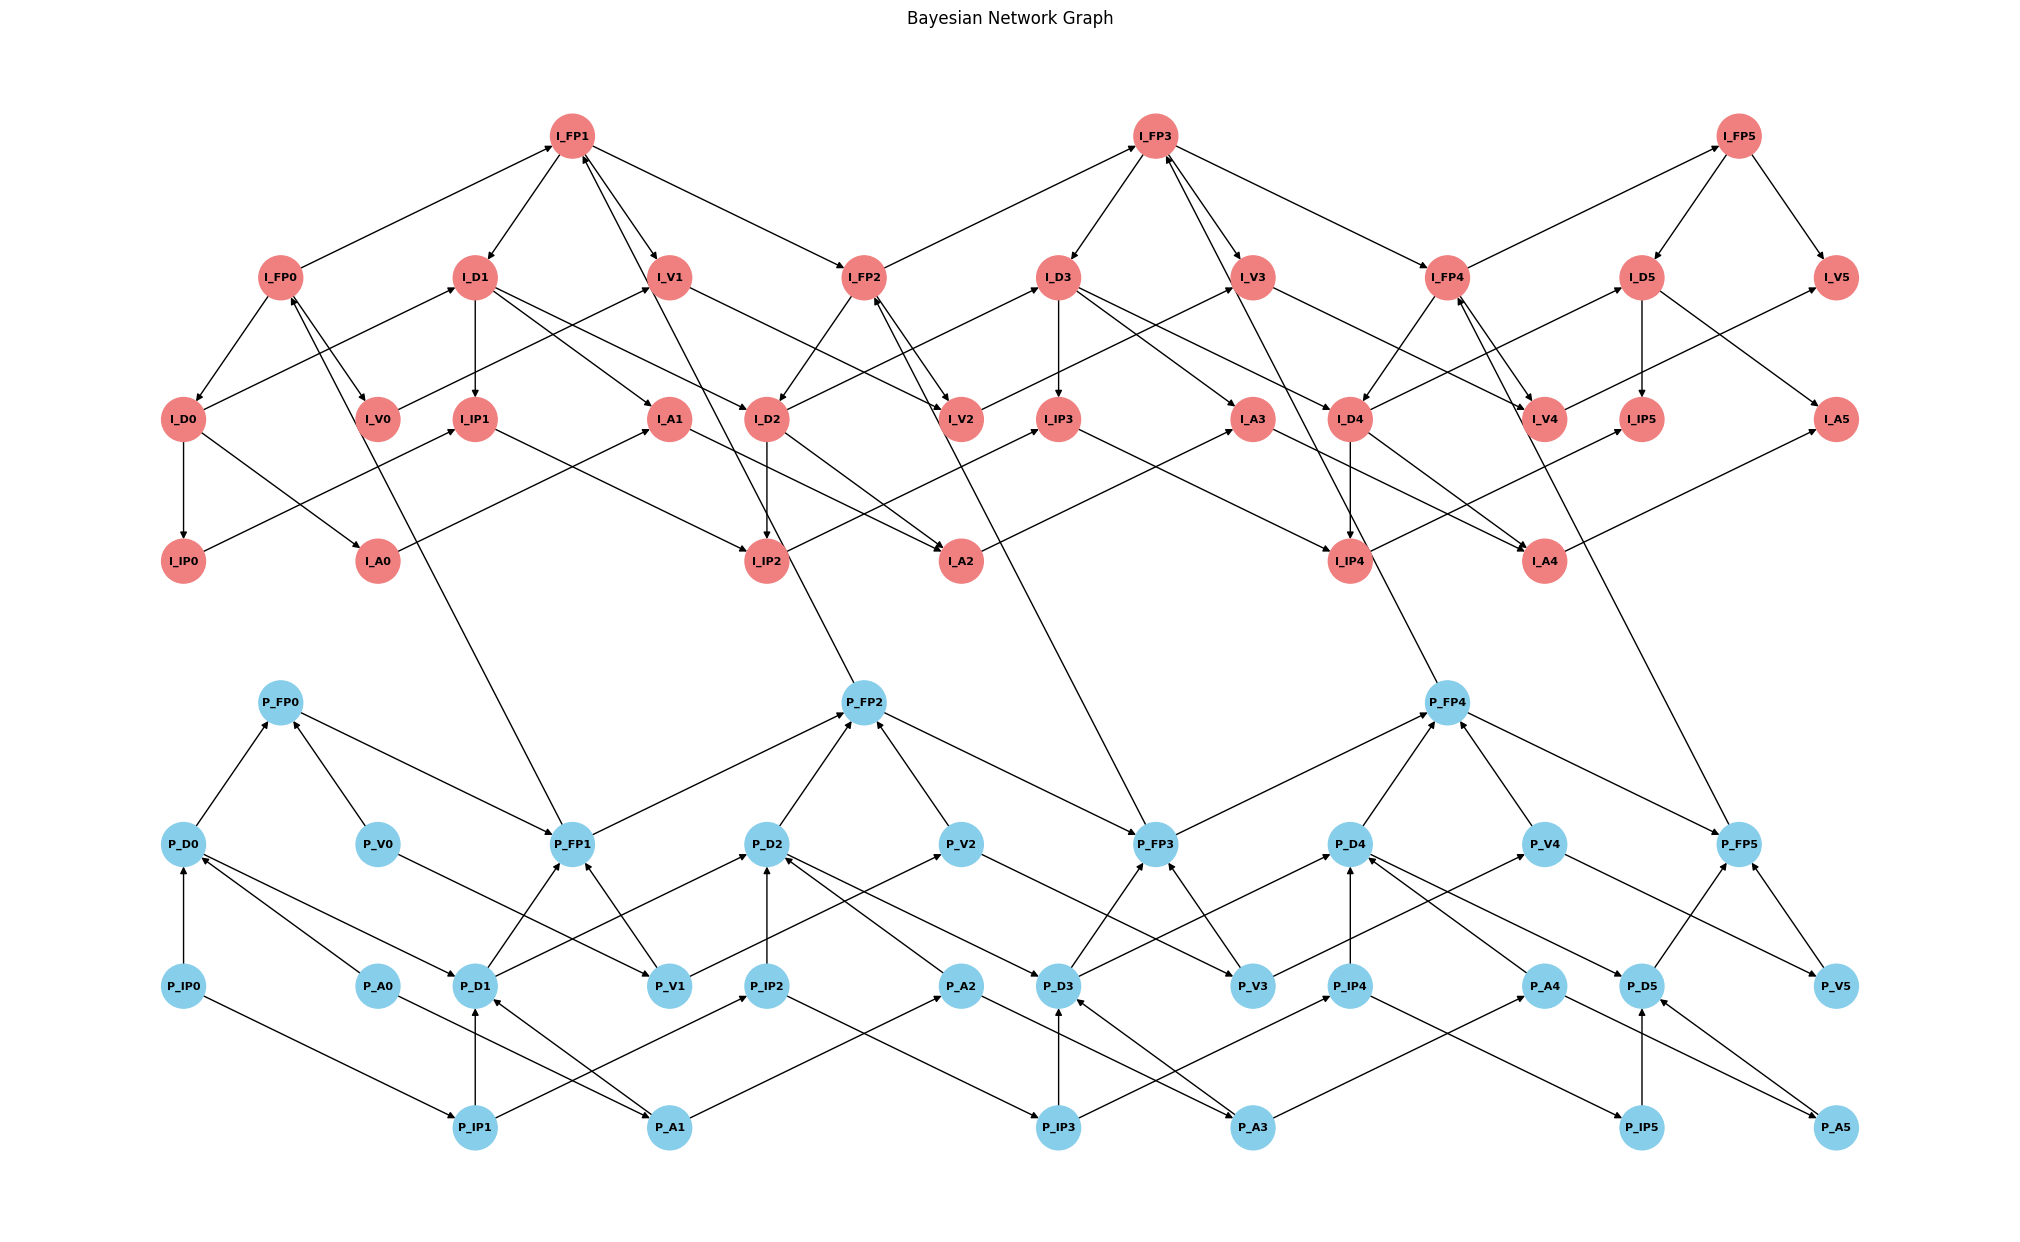

In [ ]:
import pandas as pd
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator, ExpectationMaximization
from pgmpy.models import LinearGaussianBayesianNetwork
from sklearn.model_selection import train_test_split


data = pd.read_csv('trajectory_data.csv')
data = data.round(0)

train, temp = train_test_split(data, test_size= 0.4, random_state=42) 
val, test = train_test_split(temp, test_size=0.5, random_state=42) 



# This is for training on my physics dataset
# Test.add_nodes_from(data.columns)

# model.add_nodes_from(GT.nodes())
# print(train)

# BicEdges = learn_structure(train,0)

# print(BicEdges)

model = BayesianNetwork(GT.edges())

print(model.nodes())

# network_nodes = list(Test.nodes())



# data_columns_set = set(data.columns)
# network_nodes_set = set(network_nodes)

# common_columns = data_columns_set.intersection(network_nodes_set)


# data_filtered = data[common_columns]


model.fit(train, estimator=MaximumLikelihoodEstimator)
# If you want to use Bayesian Estimation:
# GT.fit(data, estimator=BayesianEstimator, prior_type='BDeu')


if model.check_model():
    print("The model has been successfully trained and is valid!")
else:
    print("The model is not valid. Please check the CPDs.")


visualise(model, pos)

In [ ]:
from sklearn.metrics import mean_squared_error

input_features = ['P_V0', 'P_V1', 'P_V2', 'P_V3', 'P_V4', 'P_V5', 'P_A0', 'P_A1', 'P_A2', 'P_A3', 'P_A4', 'P_A5']
# input_features = []
projectile_ips = [f'P_IP{i}' for i in range(6)]
projectile_fps = [f'P_FP{i}' for i in range(6)]
projectile_ds = [f'P_D{i}' for i in range(6)]

input_features.extend(projectile_ips)
input_features.extend(projectile_fps)
input_features.extend(projectile_ds)


# Ensure that the input features exist in the validation set
input_features = [feature for feature in input_features if feature in val.columns]

# Evaluate the model using the validation data
# (Here, you could compute log likelihood, MSE, or any other relevant metric)
val_predictions = model.predict(val[input_features])
val_mse = mean_squared_error(val[list(set(model.nodes()) - set(input_features))], val_predictions)
print(f"Validation MSE: {val_mse}")

# # Test the model using the test set
# test_predictions = model.predict(test[input_features])
# test_mse = mean_squared_error(test[model.nodes()], test_predictions)
# print(f"Test MSE: {test_mse}")


NameError: name 'val' is not defined